# Состојбен управувач нагоден според зададена карактеристична равенка

In [1]:
import numpy as np
import pandas as pd
import control as ct
import plotly.graph_objects as go
from IPython.lib.display import YouTubeVideo

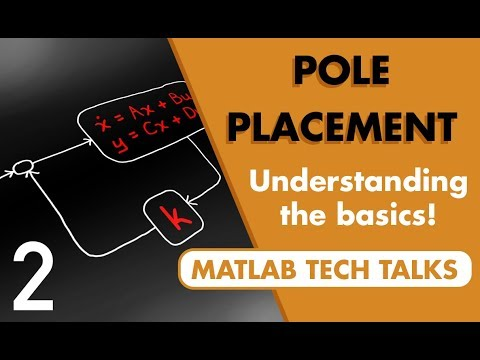

In [2]:
YouTubeVideo('FXSpHy8LvmY')

Разгледуваме дискретен систем во просторот на состојби. Имаме задача да го нагодиме системот според зададена карактеристична равенка. Целта ни е да ги нагодиме константите на управувачот така што затворениот систем ќе има полови какви што ние сме посакале при дизајнирањето на системот.

Прво го дефинираме системот во просторот на состојби.

In [3]:
A = np.array([[0, 1, 0], [0, 0, 1], [-0.0125, -0.2, -0.85]])
B = np.array([[0], [0], [1]])
C = np.array([1, 0, 0])
D = 0
sampling_time = 10

In [4]:
system = ct.ss(A, B, C, D, sampling_time)
system

A = [[ 0.      1.      0.    ]
 [ 0.      0.      1.    ]
 [-0.0125 -0.2    -0.85  ]]

B = [[0.]
 [0.]
 [1.]]

C = [[1. 0. 0.]]

D = [[0.]]

dt = 10

А потоа ги одбираме половите по наша желба.

In [5]:
P = np.array([0.05, 0.03, 0.04])
P

array([0.05, 0.03, 0.04])

И можеме да ги видиме коефициентите на карактеристичната равенка.

In [6]:
np.poly(P)

array([ 1.0e+00, -1.2e-01,  4.7e-03, -6.0e-05])

За да видиме каков излез произведува системот со оваа карактеристична равенка, ќе направиме преносна функција на која веднаш потоа ќе донесеме единечен отскочен влез за графички да видиме како излез се добива.

In [7]:
desired_system = ct.tf(1, np.poly(P), sampling_time)
desired_system


                1
---------------------------------
z^3 - 0.12 z^2 + 0.0047 z - 6e-05

dt = 10

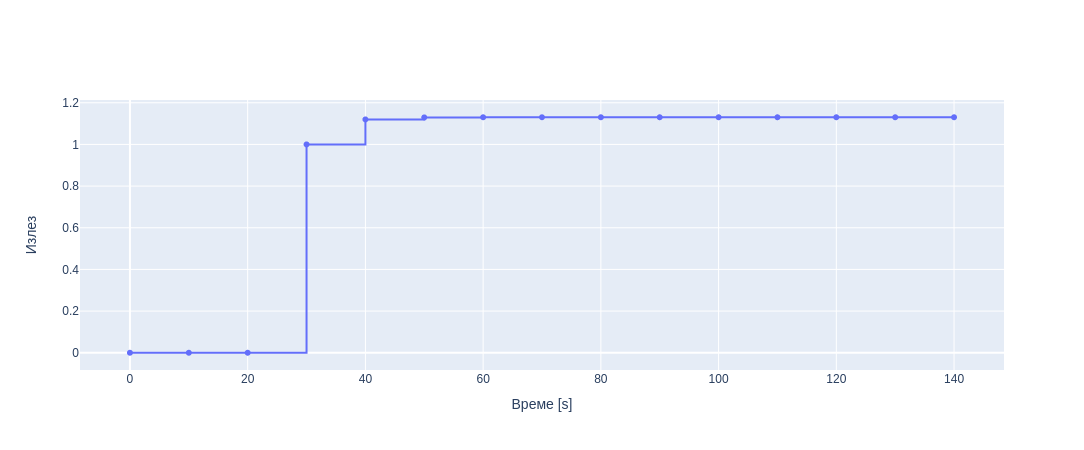

In [8]:
time = np.arange(150, step=sampling_time)
output_system = ct.step_response(desired_system, time)[1]
line_system = go.Scatter(x=time, y=output_system, name='Отворениот систем', line_shape='hv')
go.Figure([line_system], layout={'xaxis_title': 'Време [s]', 'yaxis_title': 'Излез'})

Кога ќе ги нагодиме половите по наша желба, преминуваме на пресметувањето на коефициентите на управувачот. Во библиотеката `control` има функција `place()` која ги прави овие пресметки.

In [9]:
K = ct.place(A, B, P)
K

matrix([[-0.01256, -0.1953 , -0.97   ]])

Добиените коефициенти ги користиме за да направиме модел во просторот на состојби со нова матрица на динамика $A$. Вака добиениот систем е затворен систем со управувач чии коефициенти се оние кои ги пресметавме претходно.

In [10]:
system_closed = ct.ss(A - B*K, B, C, D, sampling_time)
system_closed

A = [[ 0.0e+00  1.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00  1.0e+00]
 [ 6.0e-05 -4.7e-03  1.2e-01]]

B = [[0.]
 [0.]
 [1.]]

C = [[1. 0. 0.]]

D = [[0.]]

dt = 10

Преостанува да се осигураме дека половите на затворениот систем се оние кои ги зададовме на почетокот.

In [11]:
ct.pole(system_closed)

array([0.03, 0.04, 0.05])

Да го симулираме излезот за отворениот и за затворениот систем.

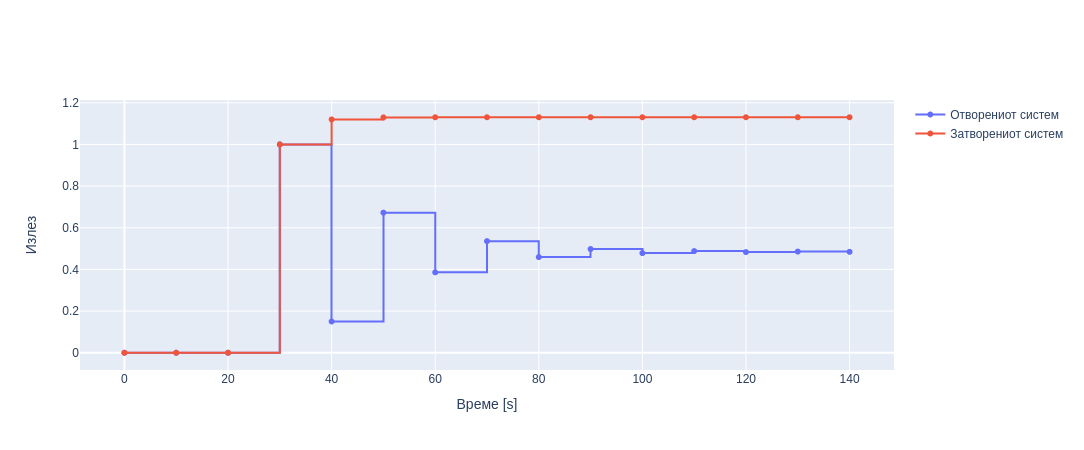

In [12]:
time = np.arange(150, step=sampling_time)
output_system = ct.step_response(system, time)[1]
output_system_closed = ct.step_response(system_closed, time)[1]
line_system = go.Scatter(x=time, y=output_system, name='Отворениот систем', line_shape='hv')
line_system_closed = go.Scatter(x=time, y=output_system_closed, name='Затворениот систем', line_shape='hv')
go.Figure([line_system, line_system_closed], layout={'xaxis_title': 'Време [s]', 'yaxis_title': 'Излез'})

Забележуваме излезот на затворениот систем е ист како што посакавме на почетокот. Но, за единечен отскочен влез затворениот систем не ја постигнуваме зададената вредност. Од графикот се забележува дека има стационарна грешка. Овој проблем се решава со тоа што ќе се скалирa матрицата $B$.

In [13]:
Kdc = ct.dcgain(system_closed)
Kdc

array(1.13040333)

In [14]:
system_closed_scaled = ct.ss(A - B*K, B / Kdc, C, D, sampling_time)
system_closed_scaled

A = [[ 0.0e+00  1.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00  1.0e+00]
 [ 6.0e-05 -4.7e-03  1.2e-01]]

B = [[0.     ]
 [0.     ]
 [0.88464]]

C = [[1. 0. 0.]]

D = [[0.]]

dt = 10

Овојпат на графикот ќе го исцртаме и новодобиениот скалиран систем.

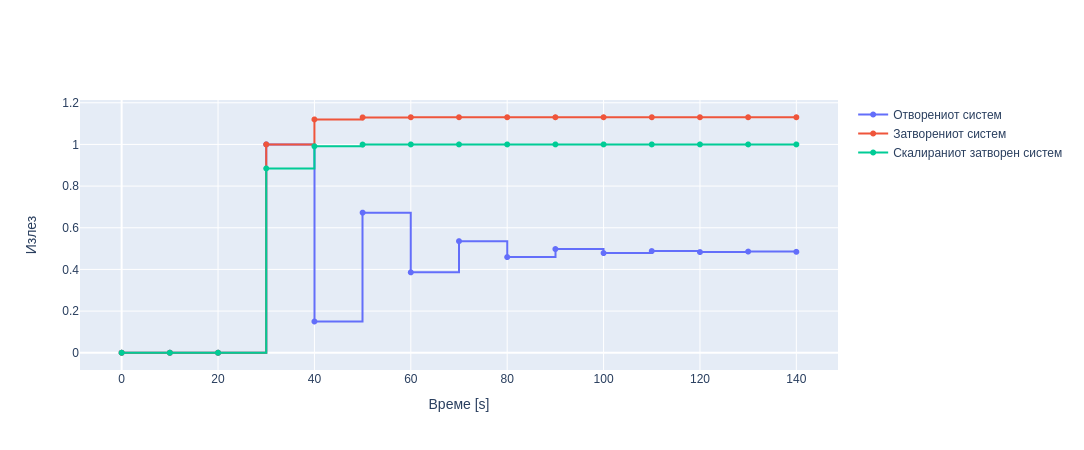

In [15]:
time = np.arange(150, step=sampling_time)
output_system = ct.step_response(system, time)[1]
output_system_closed = ct.step_response(system_closed, time)[1]
output_system_closed_scaled = ct.step_response(system_closed_scaled, time)[1]
line_system = go.Scatter(x=time, y=output_system, name='Отворениот систем', line_shape='hv')
line_system_closed = go.Scatter(x=time, y=output_system_closed, name='Затворениот систем', line_shape='hv')
line_system_closed_scaled = go.Scatter(x=time, y=output_system_closed_scaled, name='Скалираниот затворен систем', line_shape='hv')
go.Figure([line_system, line_system_closed, line_system_closed_scaled], layout={'xaxis_title': 'Време [s]', 'yaxis_title': 'Излез'})

Заклучуваме дека сега немаме стационарна грешка.